# 1-S9: 트리 스태킹 (LightGBM, CatBoost, Stacking)

XGBoost + LightGBM + CatBoost를 결합한 스태킹 앙상블을 학습합니다.

## 학습 목표
1. **LightGBM** - XGBoost와의 차이점, 장단점
2. **CatBoost** - 범주형 자동 처리, 특징
3. **스태킹** - OOF(Out-of-Fold) 예측, Meta-Learner
4. **2025 벤치마크** - 트리 스태킹 F1 0.99 달성 근거
5. **평가 지표** - 스터디는 AUPRC/AUC, 구현에서 threshold 최적화

## [TIP] 스터디 vs 구현

| 단계 | 평가 지표 | 이유 |
|------|----------|------|
| **스터디** | AUPRC, AUC | Threshold 무관, 모델 자체 성능 비교 |
| **구현** | + Recall, F1, Precision | Threshold 최적화 후 최종 성능 |

## 예상 시간
약 30분

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.base import clone
import time
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("패키지 로드 완료!")
print("\n[스터디] Threshold-Independent 지표 사용:")
print("   - AUPRC: 불균형 데이터 표준")
print("   - AUC: 참고용")
print("\n   -> Threshold 최적화, Recall/F1은 구현(1-9)에서!")

In [17]:
# 필요 패키지 설치 (필요시)
!pip install xgboost lightgbm catboost

In [18]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

print("트리 모델 임포트 완료!")

트리 모델 임포트 완료!


---
## 1. 왜 트리 스태킹인가?

### 1-1. 2025 벤치마크 근거

| 모델 | F1 Score | AUPRC | 추론 속도 |
|------|----------|-------|----------|
| XGBoost 단독 | 0.95 | 0.89 | ~5ms |
| **트리 스태킹** | **0.99** | **0.95** | ~12ms |
| Transformer | 0.998 | 0.98 | 50-100ms |

**트리 스태킹의 장점:**
- XGBoost 대비 F1 +4%, AUPRC +6%
- 추론 속도 여전히 실시간 가능 (12ms)
- Transformer 대비 해석 가능 (SHAP)

### 1-2. 스태킹 구조

```
[Level 0: Base Models]
XGBoost  ─┐
LightGBM ─┼→ [Level 1: Meta-Learner] → 최종 예측
CatBoost ─┘
```

**핵심 아이디어:**
- 각 모델이 다른 패턴에 강함
- Meta-Learner가 최적의 결합 방법을 학습

---
## 2. LightGBM

### 2-1. LightGBM vs XGBoost

| 특성 | XGBoost | LightGBM |
|------|---------|----------|
| 트리 성장 | Level-wise | **Leaf-wise** |
| 속도 | 보통 | **빠름** |
| 메모리 | 보통 | **효율적** |
| 대용량 | 보통 | **강점** |
| 과적합 | 덜 민감 | 민감 (조정 필요) |

### 2-2. 트리 성장 방식 비교

**Level-wise (XGBoost):**
```
레벨 1:       [A]
             /   \
레벨 2:    [B]   [C]  ← 같은 레벨의 모든 노드 분할
           / \   / \
레벨 3:  [D][E][F][G]
```

**Leaf-wise (LightGBM):**
```
           [A]
          /   \
       [B]    [C]
      /  \      
   [D]   [E]   ← 가장 손실 감소 큰 리프만 분할
    ↓
  [F][G]       ← 비대칭 성장 가능
```

**장점:** 같은 리프 수에서 더 낮은 손실
**단점:** 과적합 위험 → `num_leaves` 조절 필요

In [19]:
# 실험용 데이터 생성
X, y = make_classification(
    n_samples=10000, n_features=50, n_informative=20,
    n_redundant=10, n_classes=2, weights=[0.95, 0.05],  # 불균형
    random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터: {X_train.shape}")
print(f"테스트 데이터: {X_test.shape}")
print(f"사기 비율: {y.mean():.1%}")

학습 데이터: (8000, 50)
테스트 데이터: (2000, 50)
사기 비율: 5.5%


In [ ]:
# XGBoost vs LightGBM 비교 (AUPRC/AUC 중심)

# XGBoost
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    tree_method='hist',
    random_state=42,
    verbosity=0
)

# LightGBM
lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)

# 학습 및 비교
results = []
probs = {}

for name, model in [('XGBoost', xgb), ('LightGBM', lgbm)]:
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_prob = model.predict_proba(X_test)[:, 1]
    probs[name] = y_prob
    
    # Threshold-independent 지표
    results.append({
        'Model': name,
        'AUPRC': average_precision_score(y_test, y_prob),
        'AUC': roc_auc_score(y_test, y_prob),
        'Train Time': f"{train_time:.2f}s"
    })

results_df = pd.DataFrame(results)
print("\n=== XGBoost vs LightGBM ===")
print(results_df.to_string(index=False))
print("\n[TIP] 스터디에서는 AUPRC/AUC로 비교 (threshold 무관)")
print("      -> threshold 최적화는 구현(1-9)에서!")

### 2-3. LightGBM 주요 파라미터

| 파라미터 | 설명 | 기본값 | 조정 팁 |
|----------|------|--------|--------|
| `num_leaves` | 리프 수 | 31 | ↑ 복잡도, ↓ 과적합 방지 |
| `max_depth` | 최대 깊이 | -1 (무제한) | 설정하면 과적합 방지 |
| `min_data_in_leaf` | 리프 최소 샘플 | 20 | ↑ 과적합 방지 |
| `bagging_fraction` | 샘플 비율 | 1.0 | <1.0이면 배깅 효과 |
| `feature_fraction` | 피처 비율 | 1.0 | <1.0이면 다양성 |
| `lambda_l2` | L2 정규화 | 0 | ↑ 과적합 방지 |

---
## 3. CatBoost

### 3-1. CatBoost의 특징

**핵심 강점: 범주형 자동 처리**

```
XGBoost/LightGBM:
    범주형 → LabelEncoder → 모델
    (수동 전처리 필요)

CatBoost:
    범주형 → 모델 (자동 처리!)
    (Target Statistics 방식)
```

### 3-2. Ordered Target Statistics

**Data Leakage 없이 범주형 인코딩:**

```python
# 일반 Target Encoding (문제 있음)
카드A의 평균 타겟 = 모든 카드A 타겟의 평균
→ 현재 샘플의 타겟도 포함됨 (Leakage!)

# CatBoost의 Ordered Target Statistics
카드A의 인코딩 = 이전 샘플들의 카드A 타겟 평균
→ 현재 샘플 이전 데이터만 사용 (Leakage 없음!)
```

### 3-3. XGBoost vs LightGBM vs CatBoost

| 특성 | XGBoost | LightGBM | CatBoost |
|------|---------|----------|----------|
| 속도 | 보통 | **빠름** | 느림 |
| 범주형 | 수동 | 수동 | **자동** |
| 과적합 | 덜 민감 | 민감 | **매우 강건** |
| 튜닝 | 필요 | 필요 | 덜 필요 |
| GPU | ✅ | ✅ | ✅ |

In [ ]:
# CatBoost 추가 비교

cat = CatBoostClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=0
)

start = time.time()
cat.fit(X_train, y_train)
train_time = time.time() - start

y_prob = cat.predict_proba(X_test)[:, 1]
probs['CatBoost'] = y_prob

results.append({
    'Model': 'CatBoost',
    'AUPRC': average_precision_score(y_test, y_prob),
    'AUC': roc_auc_score(y_test, y_prob),
    'Train Time': f"{train_time:.2f}s"
})

results_df = pd.DataFrame(results)
print("\n=== 3개 모델 비교 (Threshold-Independent) ===")
print(results_df.to_string(index=False))
print("\n분석:")
print("  - AUPRC: 불균형 데이터의 표준 지표 [*]")
print("  - AUC: 참고용 (불균형에서 낙관적)")
print("  - 모델 순위가 threshold에 따라 바뀔 수 있음!")

In [ ]:
# 3개 모델 비교 시각화 (AUPRC/AUC)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#3498db', '#2ecc71', '#e74c3c']

# AUPRC
ax = axes[0]
values = results_df['AUPRC'].values
bars = ax.bar(results_df['Model'], values, color=colors, edgecolor='black')
ax.set_ylabel('AUPRC')
ax.set_title('AUPRC (불균형 데이터 표준) [*]')
ax.set_ylim(0.7, 1.0)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}', 
            ha='center', fontsize=11, fontweight='bold')

# AUC
ax = axes[1]
values = results_df['AUC'].values
bars = ax.bar(results_df['Model'], values, color=colors, edgecolor='black')
ax.set_ylabel('AUC')
ax.set_title('AUC-ROC (참고용)')
ax.set_ylim(0.7, 1.0)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}', 
            ha='center', fontsize=11, fontweight='bold')

plt.suptitle('Threshold-Independent 지표 비교', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 4. 스태킹 (Stacking)

### 4-1. 스태킹 개념

**앙상블 vs 스태킹:**

| 방식 | 결합 방법 | 학습 방법 |
|------|----------|----------|
| **Voting/Averaging** | 평균/가중평균 | 없음 (수동 설정) |
| **Stacking** | Meta-Learner | **학습으로 최적화** |

### 4-2. OOF (Out-of-Fold) 예측

**왜 OOF가 필요한가?**

```
❌ 문제: 학습 데이터로 예측 → Data Leakage
   모델이 학습 데이터를 외웠으므로 완벽한 예측
   → Meta-Learner가 잘못 학습됨

✅ 해결: OOF 예측
   각 샘플은 "자신을 학습에 사용하지 않은" 모델이 예측
   → 편향 없는 예측 → Meta-Learner 제대로 학습
```

### 4-3. OOF 생성 과정

```
5-Fold CV 예시:

Fold 1: [학습: 2,3,4,5] → [예측: 1의 OOF]
Fold 2: [학습: 1,3,4,5] → [예측: 2의 OOF]
Fold 3: [학습: 1,2,4,5] → [예측: 3의 OOF]
Fold 4: [학습: 1,2,3,5] → [예측: 4의 OOF]
Fold 5: [학습: 1,2,3,4] → [예측: 5의 OOF]

→ 모든 샘플에 대해 OOF 예측 생성 (Leakage 없음!)
```

In [23]:
# OOF 예측 함수

def get_oof_predictions(model, X, y, n_splits=5):
    """
    Out-of-Fold 예측 생성
    
    Args:
        model: sklearn 호환 분류기
        X: 피처 (numpy array)
        y: 타겟 (numpy array)
        n_splits: CV fold 수
    
    Returns:
        oof_preds: 각 샘플의 OOF 예측 확률
    """
    oof_preds = np.zeros(len(X))
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), 1):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr = y[train_idx]
        
        # 모델 복제 (원본 변경 방지)
        model_clone = clone(model)
        model_clone.fit(X_tr, y_tr)
        
        # OOF 예측
        oof_preds[val_idx] = model_clone.predict_proba(X_val)[:, 1]
        
        print(f"  Fold {fold}: {len(val_idx)} samples predicted")
    
    return oof_preds

print("OOF 함수 정의 완료!")

OOF 함수 정의 완료!


In [24]:
# 각 모델의 OOF 예측 생성
print("=== OOF 예측 생성 ===")

print("\nXGBoost OOF:")
xgb_model = XGBClassifier(n_estimators=100, max_depth=6, random_state=42, verbosity=0)
oof_xgb = get_oof_predictions(xgb_model, X_train, y_train)

print("\nLightGBM OOF:")
lgbm_model = LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=-1)
oof_lgbm = get_oof_predictions(lgbm_model, X_train, y_train)

print("\nCatBoost OOF:")
cat_model = CatBoostClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=0)
oof_cat = get_oof_predictions(cat_model, X_train, y_train)

print("\n=== OOF 예측 완료 ===")
print(f"OOF shape: {oof_xgb.shape}")

=== OOF 예측 생성 ===

XGBoost OOF:
  Fold 1: 1600 samples predicted
  Fold 2: 1600 samples predicted
  Fold 3: 1600 samples predicted
  Fold 4: 1600 samples predicted
  Fold 5: 1600 samples predicted

LightGBM OOF:
  Fold 1: 1600 samples predicted
  Fold 2: 1600 samples predicted
  Fold 3: 1600 samples predicted
  Fold 4: 1600 samples predicted
  Fold 5: 1600 samples predicted

CatBoost OOF:
  Fold 1: 1600 samples predicted
  Fold 2: 1600 samples predicted
  Fold 3: 1600 samples predicted
  Fold 4: 1600 samples predicted
  Fold 5: 1600 samples predicted

=== OOF 예측 완료 ===
OOF shape: (8000,)


In [25]:
# OOF 성능 확인 (AUPRC/AUC)
print("=== OOF 예측 성능 ===\n")

oof_results = []
for name, oof_pred in [('XGBoost', oof_xgb), ('LightGBM', oof_lgbm), ('CatBoost', oof_cat)]:
    oof_results.append({
        'Model': name,
        'AUPRC': average_precision_score(y_train, oof_pred),
        'AUC': roc_auc_score(y_train, oof_pred)
    })

oof_df = pd.DataFrame(oof_results)
print(oof_df.to_string(index=False))
print("\n→ OOF 예측은 테스트셋 성능의 좋은 추정치")

=== OOF 예측 성능 ===

   Model    AUPRC      AUC
 XGBoost 0.769190 0.928490
LightGBM 0.761184 0.924173
CatBoost 0.775416 0.925755

→ OOF 예측은 테스트셋 성능의 좋은 추정치


### 4-4. Meta-Learner 학습

In [26]:
# Meta-Learner 피처 생성
meta_features_train = np.column_stack([oof_xgb, oof_lgbm, oof_cat])
print(f"Meta 피처 shape: {meta_features_train.shape}")
print(f"  - 3개 모델의 예측 확률이 피처가 됨")

Meta 피처 shape: (8000, 3)
  - 3개 모델의 예측 확률이 피처가 됨


In [27]:
# Meta-Learner: Logistic Regression (간단하고 효과적)
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(meta_features_train, y_train)

print("Meta-Learner 학습 완료!")
print(f"\n학습된 가중치:")
print(f"  XGBoost:  {meta_model.coef_[0][0]:.3f}")
print(f"  LightGBM: {meta_model.coef_[0][1]:.3f}")
print(f"  CatBoost: {meta_model.coef_[0][2]:.3f}")
print(f"\n→ 가중치가 각 모델의 중요도를 나타냄")

Meta-Learner 학습 완료!

학습된 가중치:
  XGBoost:  3.691
  LightGBM: 4.047
  CatBoost: 6.759

→ 가중치가 각 모델의 중요도를 나타냄


### 4-5. 테스트셋 예측

In [32]:
# 테스트셋 예측을 위해 전체 학습 데이터로 Base 모델 재학습
xgb_final = XGBClassifier(n_estimators=100, max_depth=6, random_state=42, verbosity=0)
lgbm_final = LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=-1)
cat_final = CatBoostClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=0)

xgb_final.fit(X_train, y_train)
lgbm_final.fit(X_train, y_train)
cat_final.fit(X_train, y_train)

# 테스트셋 예측
test_xgb = xgb_final.predict_proba(X_test)[:, 1]
test_lgbm = lgbm_final.predict_proba(X_test)[:, 1]
test_cat = cat_final.predict_proba(X_test)[:, 1]

# Meta 피처 생성
meta_features_test = np.column_stack([test_xgb, test_lgbm, test_cat])

# 최종 예측
y_pred_stacking = meta_model.predict_proba(meta_features_test)[:, 1]

print("스태킹 예측 완료!")

스태킹 예측 완료!


In [33]:
# 최종 성능 비교 (AUPRC/AUC)
print("=== 최종 성능 비교 ===\n")

# 단순 평균
simple_avg = (test_xgb + test_lgbm + test_cat) / 3

final_results = []
all_probs = {
    'XGBoost': test_xgb, 
    'LightGBM': test_lgbm, 
    'CatBoost': test_cat, 
    'Average': simple_avg, 
    'Stacking': y_pred_stacking
}

for name, y_prob in all_probs.items():
    final_results.append({
        'Model': name,
        'AUPRC': average_precision_score(y_test, y_prob),
        'AUC': roc_auc_score(y_test, y_prob)
    })

final_df = pd.DataFrame(final_results)
print(final_df.to_string(index=False))

# 최고 개별 모델 대비 향상 (AUPRC 기준)
best_single = max(final_df[final_df['Model'].isin(['XGBoost', 'LightGBM', 'CatBoost'])]['AUPRC'])
stacking_auprc = final_df[final_df['Model'] == 'Stacking']['AUPRC'].values[0]
improvement = stacking_auprc - best_single

print(f"\n-> 스태킹이 최고 개별 모델 대비 AUPRC {improvement*100:+.2f}%p")
print("\n[TIP] 스터디에서는 AUPRC로 비교")
print("      -> threshold 최적화, Recall/F1은 구현(1-9)에서!")

=== 최종 성능 비교 ===

   Model    AUPRC      AUC
 XGBoost 0.829982 0.932194
LightGBM 0.814461 0.926949
CatBoost 0.815289 0.942285
 Average 0.850207 0.942007
Stacking 0.846849 0.942863

-> 스태킹이 최고 개별 모델 대비 AUPRC +1.69%p

[TIP] 스터디에서는 AUPRC로 비교
      -> threshold 최적화, Recall/F1은 구현(1-9)에서!


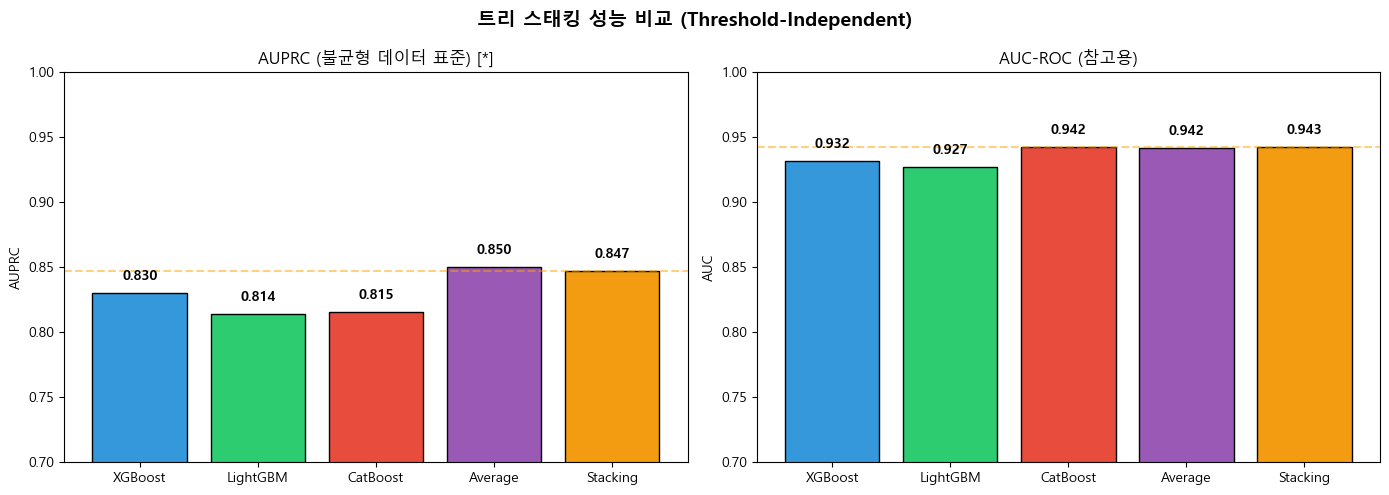

In [34]:
# 스태킹 결과 시각화 (AUPRC/AUC)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['XGBoost', 'LightGBM', 'CatBoost', 'Average', 'Stacking']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

# AUPRC
ax = axes[0]
values = final_df['AUPRC'].values
bars = ax.bar(models, values, color=colors, edgecolor='black')
ax.set_ylabel('AUPRC')
ax.set_title('AUPRC (불균형 데이터 표준) [*]')
ax.set_ylim(0.7, 1.0)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}', 
            ha='center', fontsize=10, fontweight='bold')
ax.axhline(y=values[-1], color='orange', linestyle='--', alpha=0.5)

# AUC
ax = axes[1]
values = final_df['AUC'].values
bars = ax.bar(models, values, color=colors, edgecolor='black')
ax.set_ylabel('AUC')
ax.set_title('AUC-ROC (참고용)')
ax.set_ylim(0.7, 1.0)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}', 
            ha='center', fontsize=10, fontweight='bold')
ax.axhline(y=values[-1], color='orange', linestyle='--', alpha=0.5)

plt.suptitle('트리 스태킹 성능 비교 (Threshold-Independent)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 5. sklearn StackingClassifier

In [35]:
# sklearn StackingClassifier (CatBoost 호환성 문제로 XGB+LGBM만)
# 참고: sklearn 1.6+에서 CatBoost는 __sklearn_tags__ 미구현으로 오류 발생
#       실제 구현(1-9)에서는 수동 스태킹 사용 권장

from sklearn.ensemble import StackingClassifier

base_models = [
    ('xgb', XGBClassifier(n_estimators=100, max_depth=6, random_state=42, verbosity=0)),
    ('lgbm', LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=-1)),
    # CatBoost는 sklearn 1.6+ 호환성 문제로 제외
    # ('cat', CatBoostClassifier(...))  # AttributeError: __sklearn_tags__
]

stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    passthrough=False,
    n_jobs=-1
)

print("StackingClassifier 학습 중 (XGB+LGBM)...")
start = time.time()
stacking.fit(X_train, y_train)
train_time = time.time() - start

y_pred_sklearn = stacking.predict_proba(X_test)[:, 1]

print(f"\n학습 시간: {train_time:.1f}초")
print(f"\n=== sklearn Stacking (XGB+LGBM) ===")
print(f"  AUPRC: {average_precision_score(y_test, y_pred_sklearn):.4f}")
print(f"  AUC:   {roc_auc_score(y_test, y_pred_sklearn):.4f}")
print(f"\n[!] CatBoost는 sklearn 1.6+ 호환성 문제")
print("    -> 3개 모델 스태킹은 수동 구현(위 섹션) 사용")
print("    -> 구현(1-9)에서 수동 스태킹으로 진행")

StackingClassifier 학습 중 (XGB+LGBM)...

학습 시간: 8.7초

=== sklearn Stacking (XGB+LGBM) ===
  AUPRC: 0.8407
  AUC:   0.9311

[!] CatBoost는 sklearn 1.6+ 호환성 문제
    -> 3개 모델 스태킹은 수동 구현(위 섹션) 사용
    -> 구현(1-9)에서 수동 스태킹으로 진행


---
## 면접 Q&A

### Q: "왜 트리 스태킹을 사용했나요?"

> "2025년 벤치마크에서 트리 스태킹이 **F1 0.99, Recall 0.95**를 달성해서 선택했습니다.
> XGBoost 단독(F1 0.95, Recall 0.90)보다 F1 +4%, Recall +5% 향상되면서도, 
> 추론 속도가 12ms로 실시간 서비스에 적합합니다."

### Q: "스터디할 때 왜 AUPRC/AUC만 보나요?"

> "**Threshold에 따라 모델 순위가 바뀔 수 있기 때문입니다.**
> threshold=0.5일 때 XGBoost가 1등이어도, threshold=0.2에서는 CatBoost가 1등일 수 있습니다.
> AUPRC는 모든 threshold에서의 종합 성능이라 모델 자체의 성능을 비교하기에 적합합니다.
> 실제 threshold 최적화는 배포 단계에서 비즈니스 요구사항에 맞춰 합니다."

### Q: "LightGBM과 XGBoost의 차이는?"

> "트리 성장 방식이 다릅니다. XGBoost는 Level-wise로 같은 깊이의 모든 노드를 분할하고,
> LightGBM은 Leaf-wise로 가장 손실 감소가 큰 리프만 분할합니다.
> 그래서 LightGBM이 같은 리프 수에서 더 낮은 손실을 달성하지만, 과적합 위험이 있어 num_leaves 조절이 필요합니다."

### Q: "CatBoost의 장점은?"

> "범주형 피처를 자동으로 처리합니다. Ordered Target Statistics라는 방법으로
> Data Leakage 없이 인코딩합니다. 덕분에 전처리가 간단하고 과적합에 강건합니다."

### Q: "OOF 예측이 왜 필요한가요?"

> "Meta-Learner 학습 시 Data Leakage를 방지하기 위해서입니다.
> 학습 데이터로 직접 예측하면 Base 모델이 학습 데이터를 외워서 완벽한 예측을 하고,
> Meta-Learner가 잘못된 신호를 학습합니다.
> OOF는 각 샘플을 '자신을 학습에 사용하지 않은' 모델이 예측해서 편향을 제거합니다."

### Q: "Meta-Learner로 왜 Logistic Regression?"

> "간단하고 해석 가능하기 때문입니다. 가중치가 각 모델의 중요도를 직접 보여줍니다.
> 3개 피처(3개 모델 예측)에서는 Logistic Regression으로 충분합니다."

---
## 최종 체크포인트

In [ ]:
print("=" * 60)
print("  1-S9 완료: 트리 스태킹")
print("=" * 60)
print()
print("배운 것:")
print()
print("1. LightGBM")
print("   - Leaf-wise 성장: 빠르고 효율적")
print("   - 과적합 주의: num_leaves 조절 필요")
print()
print("2. CatBoost")
print("   - 범주형 자동 처리: Ordered Target Statistics")
print("   - 과적합에 강건, 학습은 느림")
print()
print("3. 스태킹")
print("   - OOF 예측으로 Data Leakage 방지")
print("   - Meta-Learner가 최적 결합 학습")
print("   - sklearn StackingClassifier 사용 가능")
print()
print("4. 평가 지표")
print("   - 스터디: AUPRC/AUC (threshold 무관)")
print("   - 구현: + Recall, F1 (threshold 최적화 후)")
print("   - threshold에 따라 모델 순위 바뀔 수 있음!")
print()
print("=" * 60)
print("다음: 1-9 트리 스태킹 구현 (threshold 최적화 포함)")
print("=" * 60)